In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv('https://download1654.mediafire.com/gbj92gtz6pagbWsqcHiaIT6qX2bxgw9TIgkaa7uT6RMsBy9QfOQJPI1-97n25fwrmbMoglGkFm0TG3VYlHuyycI1PqK6VVMaZX9hB9_-1ejuq4TXQK5vsrxmUrNbzO2vdgJoCIKF9qqOJF3I1tuJKYPPvOAW9eiMim4cDokI4rpI8g/l1mqeshcjvy2orp/creditcard.csv')

In [3]:
df = df.drop(['Time'], axis=1)

In [22]:
df.shape

(284807, 30)

In [23]:
df.columns.values

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'], dtype=object)

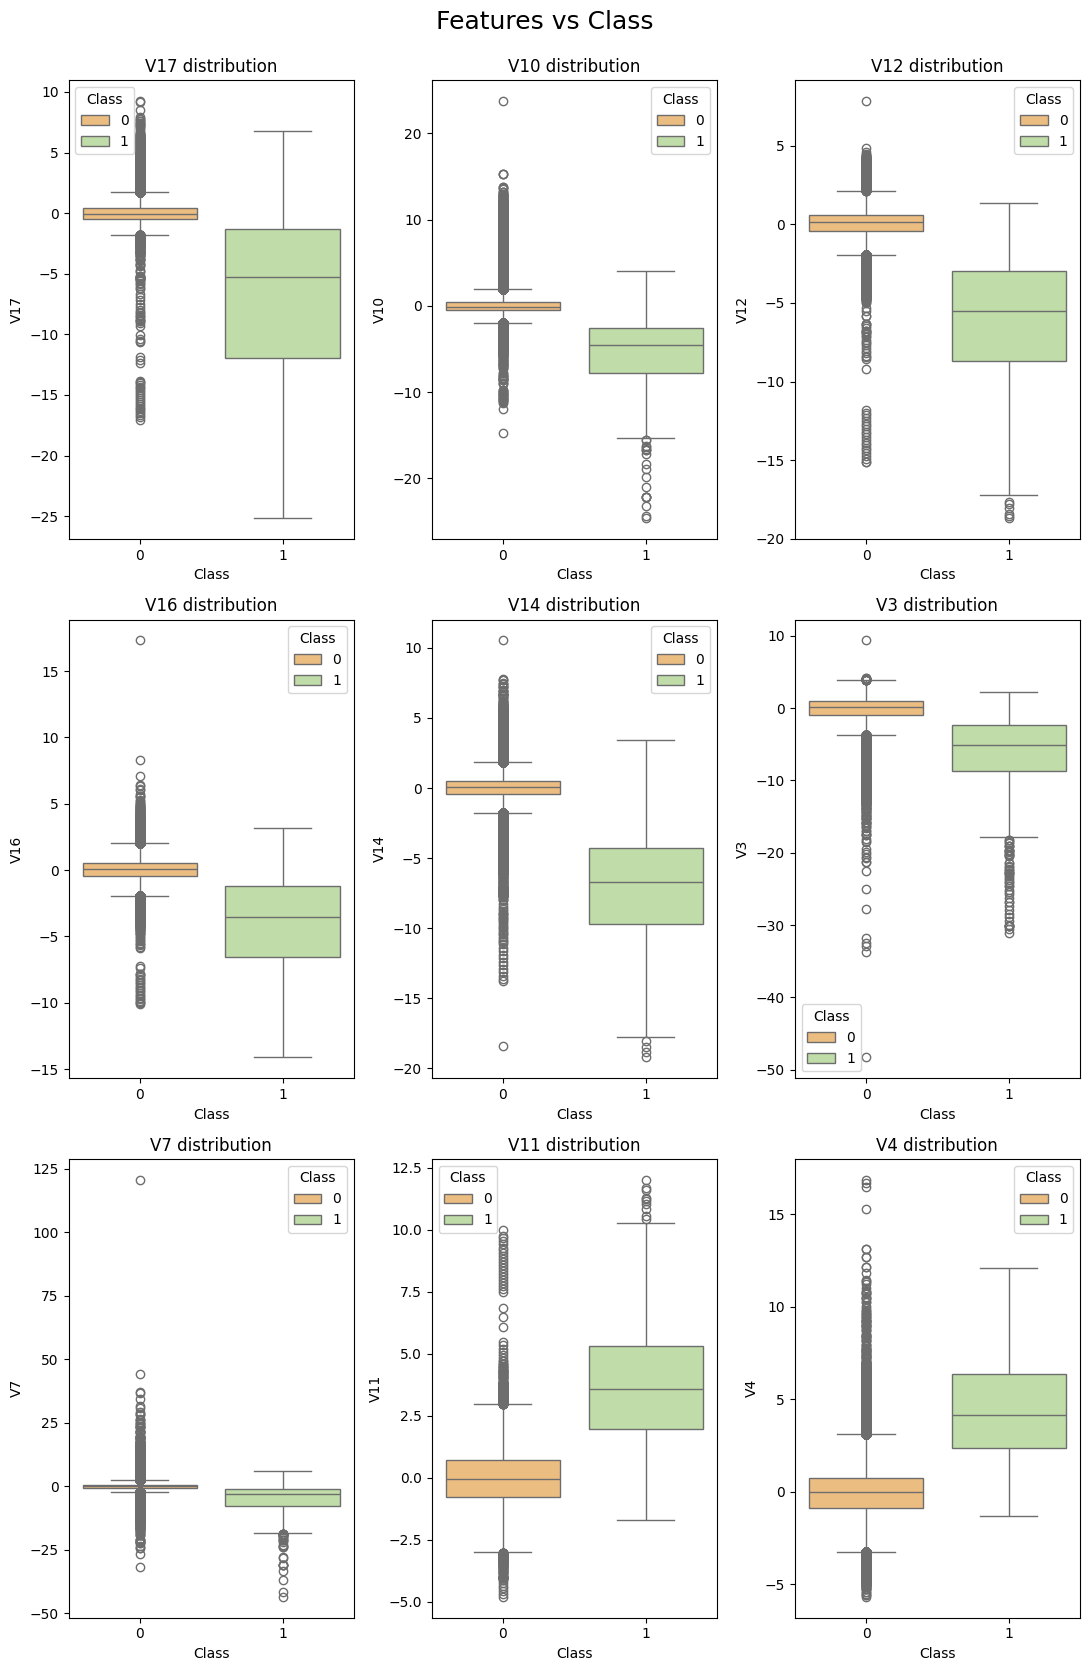

In [7]:
features = ['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4']
rows, cols = 3, 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(11, 17))
fig.suptitle('Features vs Class\n', size=18)

for i in range(rows):
    for j in range(cols):
        feature_index = i * cols + j
        if feature_index < len(features):
            feature = features[feature_index]
            #sns.boxplot(ax=axes[i, j], data=df, x='Class', y=feature, palette='Spectral')
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=feature, hue='Class', palette='Spectral')
            axes[i, j].set_title(f"{feature} distribution")

plt.tight_layout()
plt.show()


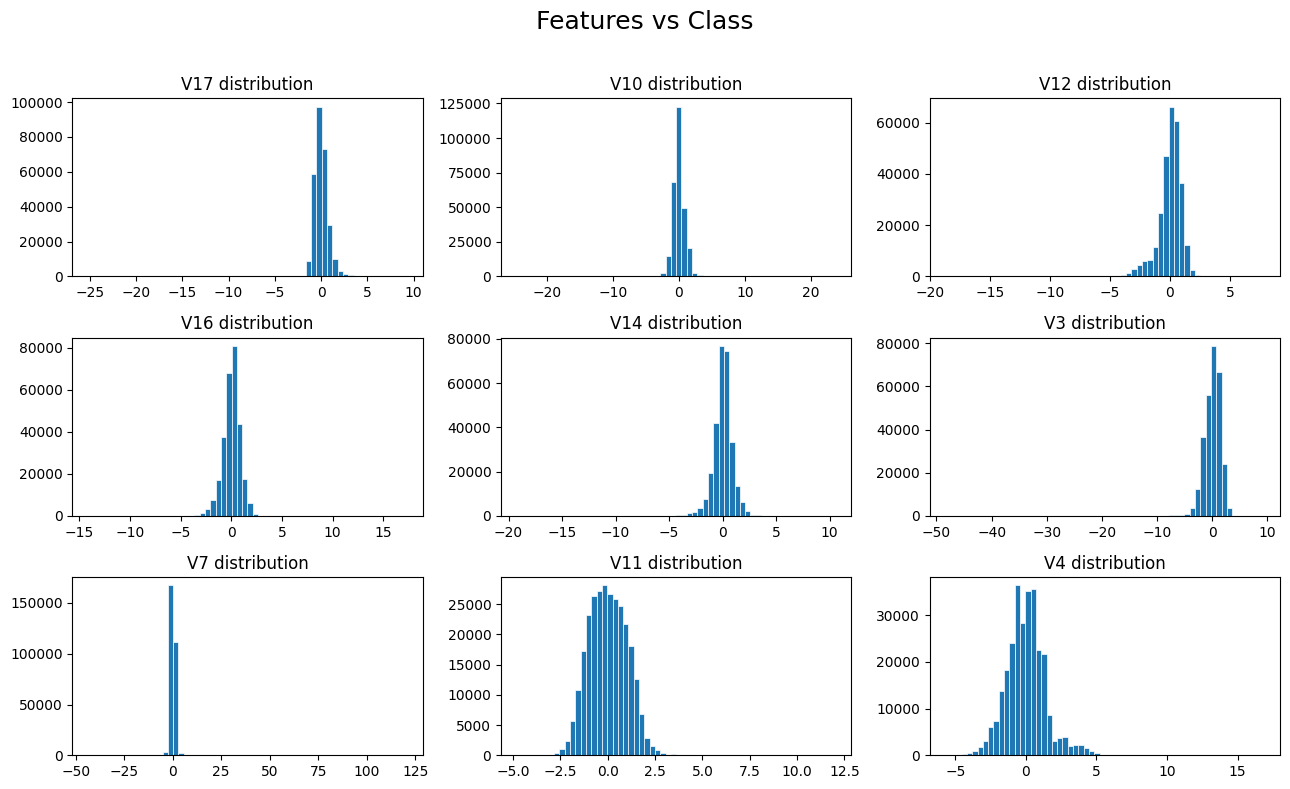

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Features vs Class\n', size = 18)

for i in range(rows):
  for j in range(cols):
    feature_index = i * cols + j
    if feature_index < len(features):
      feature = features[feature_index]
      axes[i, j].hist(df[feature], bins=60, linewidth=0.5, edgecolor="white")
      axes[i, j].set_title(f"{feature} distribution")

plt.tight_layout()
plt.show()

## Tukey's IQR method

In [18]:
def IQR_method (df,n,features):

    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the Tukey IQR method.
    """

    outlier_list = []

    for column in features:

        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)

        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index

        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]

    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])

    return multiple_outliers

In [5]:
allfeatures = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [26]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [25]:
#allfeatures = df.columns
# detecting outliers
Outliers_IQR = IQR_method(df,1, allfeatures)

# dropping outliers
#df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of outliers is: 31904


## Standard deviation method

In [60]:
def StDev_method (df,n,features):

    """
    Takes a dataframe df of features and returns an index list corresponding to the observations
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []

    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()

        # calculate the cutoff value
        cut_off = data_std * 3

        # Determining a list of indices of outliers for feature column
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index

        # appending the found outlier indices for column to the list of outlier indices
        outlier_indices.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])

    #subset_df = df.loc[multiple_outliers]
    return multiple_outliers

In [61]:
# detecting outliers
Outliers_StDev = StDev_method(df,1,allfeatures)
# dropping outliers
#df_out2 = df.drop(Outliers_StDev, axis = 0).reset_index(drop=True)

Total number of outliers is: 4076


## Z-score method

In [85]:
from scipy.stats import median_abs_deviation

def z_scoremod_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations
    containing more than n outliers according to the z-score modified method.
    """
    outlier_list = []

    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        MAD = median_abs_deviation

        mod_z_score = abs(0.6745*(df[column] - data_mean)/MAD(df[column]) )

        # Determining a list of indices of outliers for feature column
        outlier_list_column =  df[mod_z_score >threshold].index

        # appending the found outlier indices for column to the list of outlier indices
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of outlier records
    df1 = df[mod_z_score >threshold]
    print('Total number of outliers is:', df1.shape[0])

    return multiple_outliers

In [86]:
# detecting outliers
Outliers_z_score = z_scoremod_method(df,1, allfeatures)

# dropping outliers
#df_out4 = df.drop(Outliers_z_score, axis = 0).reset_index(drop=True)

Total number of outliers is: 33055


In [6]:
df5 = df.copy()
df5 = df5.drop(['Class'], axis=1)

In [7]:
model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(df5)

scores=model.decision_function(df5)
anomaly=model.predict(df5)

df5['scores']=scores
df5['anomaly']=anomaly

df5.head(10)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,scores,anomaly
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.071054,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.083827,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,-0.008545,-1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.038668,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.071393,1
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.083595,1
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.077085,1
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,-0.017048,-1
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0.048578,1
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0.078492,1


In [92]:
anomaly = df5.loc[df5['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

df5[df5['anomaly']==-1].head(10)
#df_out5 = df5.drop(anomaly_index, axis = 0).reset_index(drop=True)

Total number of outliers is: 28481


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,scores,anomaly
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,-0.015230,-1
18,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,0.345173,...,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,-0.032785,-1
51,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,-0.230873,...,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,-0.085536,-1
69,-1.923213,-0.870482,2.320170,1.988776,0.417091,-0.380014,0.472139,-0.557333,-0.649079,1.410889,...,-0.779268,1.086055,0.518863,-0.363712,3.065576,-0.589022,-0.396110,35.00,-0.015773,-1
82,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,1.46,-0.104213,-1
83,-1.198968,-1.474100,1.840326,-4.515824,0.327567,-0.174469,0.959726,-1.026456,1.700435,-0.078942,...,0.334614,-0.364541,-0.310186,-0.302599,-1.243924,-1.123457,-0.734351,89.17,-0.030218,-1
85,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,-0.614312,...,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,-0.036838,-1
89,-0.773293,-4.146007,-0.932038,0.027094,-1.698307,0.460188,0.737344,-0.314216,-0.842673,0.017276,...,0.026123,-1.134769,-0.654958,0.098386,-0.209150,-0.171709,0.208057,1142.02,-0.017535,-1
102,0.298503,2.142722,-1.542143,1.561332,0.938108,-2.145673,1.405569,-0.778459,0.328636,0.127497,...,-0.000235,0.092174,0.586205,-0.397314,-0.480949,0.251145,-0.242279,0.78,-0.005122,-1
104,-1.766645,2.352984,-0.009955,-0.363736,1.460953,-0.204833,0.905819,-3.384123,0.388546,0.791069,...,-0.883218,-0.247698,-0.758606,0.086450,0.202790,-0.898858,-0.944337,0.76,-0.018398,-1


## DBSCAN

In [5]:
df6 = df.copy()
df6 = df6.drop(['Class'], axis=1)

In [ ]:
# scale data first
X = StandardScaler().fit_transform(df6.values)

db = DBSCAN(eps=2.0, min_samples=5).fit(X)
labels = db.labels_
labels

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('The number of clusters in dataset is:', n_clusters_)

pd.Series(labels).value_counts()

In [7]:
df4 = df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15']]

## Auto Histogram

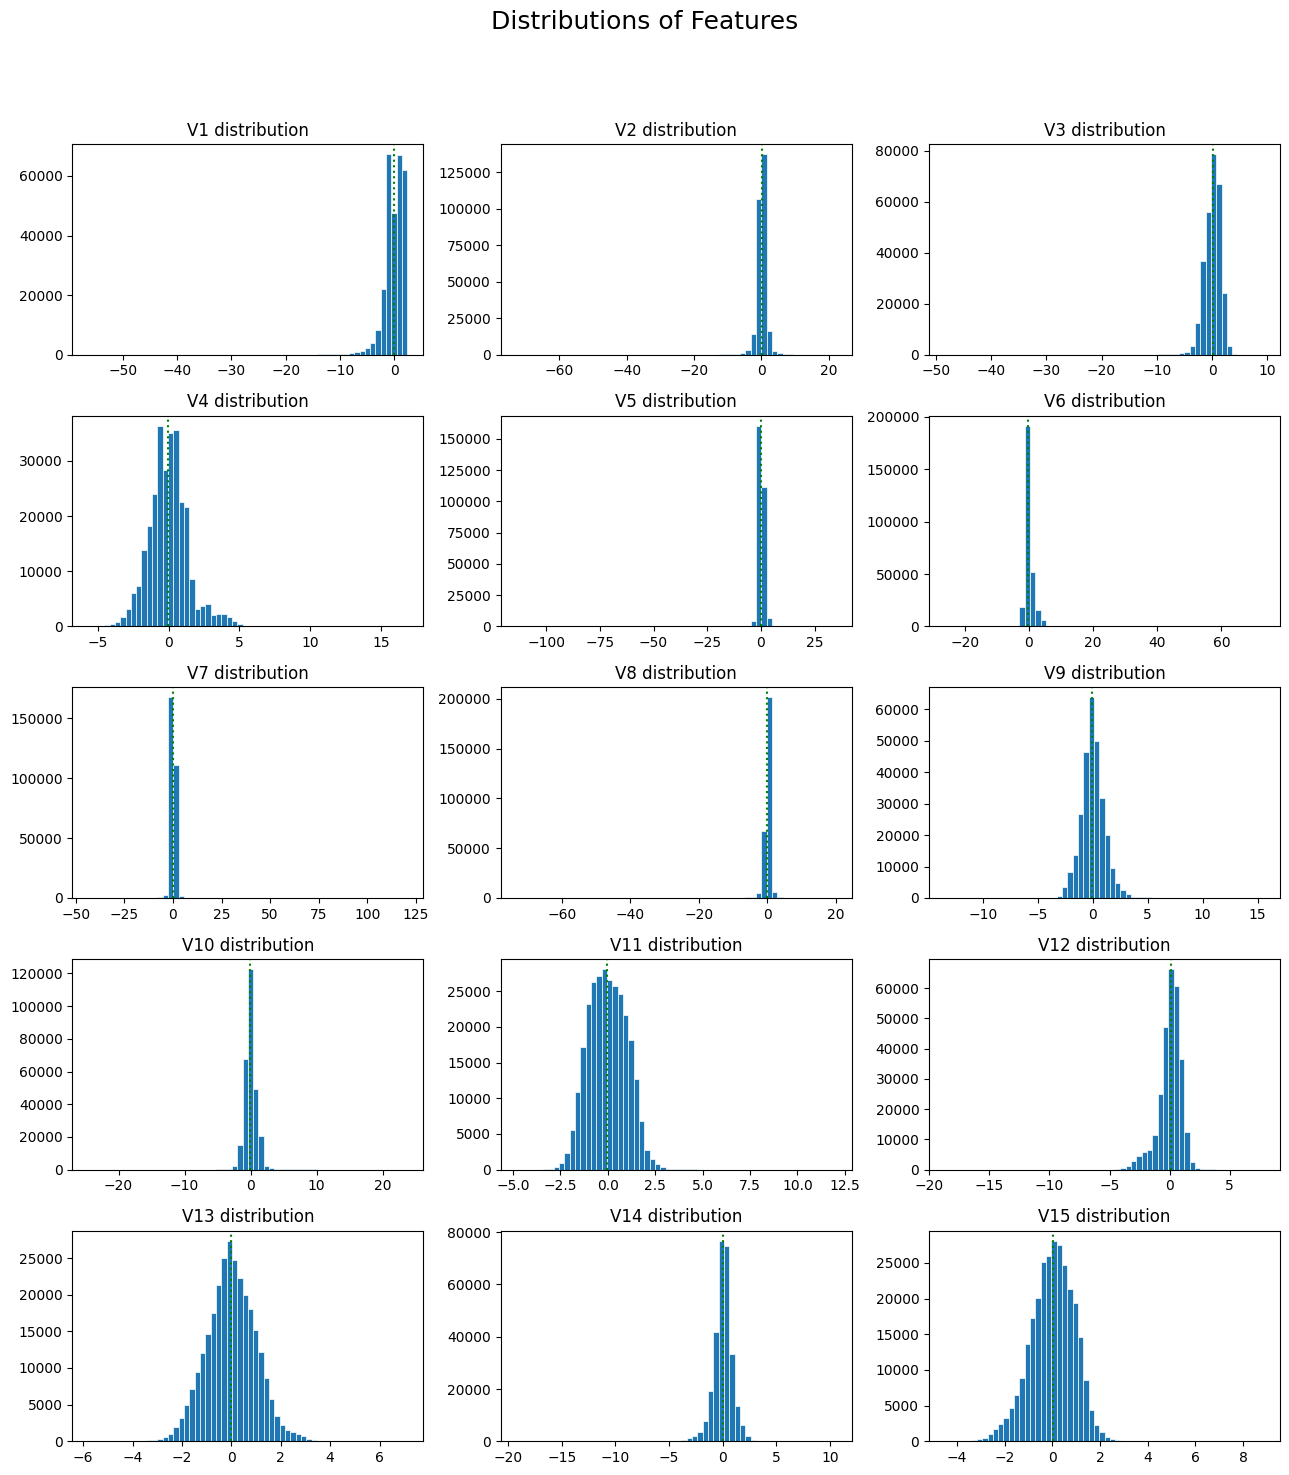

In [10]:
def plot_feature_distributions(dataframe, figsize=(13, 15), bins=60):

    num_features = len(dataframe.columns)
    num_rows = (num_features - 1) // 3 + 1
    num_cols = min(num_features, 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    fig.suptitle('Distributions of Features\n', size=18)

    flattened_axes = axes.flatten()

    for i, feature in enumerate(dataframe.columns):
        flattened_axes[i].hist(dataframe[feature], bins=bins, linewidth=0.5, edgecolor="white")
        flattened_axes[i].axvline(np.median(dataframe[feature]), ls=':', c='g', label="Median")
        flattened_axes[i].set_title(f"{feature} distribution")

    # Hide empty subplots if any
    for j in range(num_features, num_rows * num_cols):
        fig.delaxes(flattened_axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid title overlap
    plt.show()



# Example usage:
plot_feature_distributions(df4)


[Ref](https://https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods)